<a href="https://colab.research.google.com/github/hichanmedia/tiscon9/blob/main/4_3_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#テンプレート画像を用いる方法の改善


* 役割の人数によってテンプレートフォルダを分ける方法を検討
* 複数フォルダを作成し、そこに保存されているデータをtemplateとして読み込む
* 入力画像は「path」フォルダにある




### ライブラリのインストール

In [ ]:
import cv2
import numpy as np
import os

# 画像の読み込みや保存に必要なライブラリが無ければインストール
!pip install opencv-python-headless

### 円検出とラベリング

In [ ]:
# パラメータを調整して円を検出
def detect_circles(image, dp=1.2, minDist=30, param1=50, param2=30, minRadius=15, maxRadius=100):
    # グレースケールに変換
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 画像の平滑化
    gray = cv2.medianBlur(gray, 5)

    # Hough Circle Transformで円を検出
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist,
                               param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        return circles[0, :]
    else:
        return None


def label_circles(image, circles):
    output = image.copy()
    for i, circle in enumerate(circles):
        x, y, r = circle
        # 円を描画
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)
        # ラベリング (番号をつける)
        cv2.putText(output, str(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    return output


### 画像を読み込み、テンプレートを作成

In [ ]:
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive')

# テンプレートフォルダのルートディレクトリ
root_folder = "/content/drive/My Drive/temp/"

# 円情報を保存するリスト
template_features = []

# 画像フォルダを再帰的に探索
for dirpath, dirnames, filenames in os.walk(root_folder):
    for image_file in filenames:
        if os.path.splitext(image_file)[1].lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
            image_path = os.path.join(dirpath, image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load {image_file}")
                continue

            circles = detect_circles(image)
            if circles is not None:
                template_features.append({"file_name": image_file, "circles": circles, "folder": dirpath})
                print(f"Circles detected and saved for {image_file}")
            else:
                print(f"No circles found in {image_file}")

Mounted at /content/drive
Circles detected and saved for スライド18.JPG
Circles detected and saved for スライド1.JPG
Circles detected and saved for スライド25.JPG
Circles detected and saved for スライド21.JPG
Circles detected and saved for スライド8.JPG
Circles detected and saved for スライド22.JPG
Circles detected and saved for スライド24.JPG
Circles detected and saved for スライド14.JPG
Circles detected and saved for スライド7.JPG
Circles detected and saved for スライド19.JPG
Circles detected and saved for スライド3.JPG
Circles detected and saved for スライド5.JPG
Circles detected and saved for スライド23.JPG
Circles detected and saved for スライド4.JPG
Circles detected and saved for スライド20.JPG
Circles detected and saved for スライド6.JPG
Circles detected and saved for スライド16.JPG
Circles detected and saved for スライド11.JPG
Circles detected and saved for スライド13.JPG
Circles detected and saved for スライド10.JPG
Circles detected and saved for スライド17.JPG
Circles detected and saved for スライド2.JPG
Circles detected and saved for スライド

In [ ]:
# テンプレート情報を確認
#for template in template_features:
   # print(f"Template from {template['file_name']} contains circles: {template['circles']}")


Template from スライド8.JPG contains circles: [[ 772  283   38]
 [ 868  499   34]
 [ 754  596   43]
 [ 524  596   43]
 [ 868  596   42]
 [ 635  497   34]
 [ 639  596   43]
 [ 413  596   42]
 [ 986  319   28]
 [ 423   79   33]
 [ 310  319   27]
 [ 719  106   32]
 [ 537  268   28]
 [ 411  495   32]
 [  94  445   32]
 [1205  415   32]
 [ 883  563   78]
 [ 787  497   62]
 [ 783  253   41]]
Template from スライド10.JPG contains circles: [[ 868  499   34]
 [ 754  596   43]
 [ 524  596   43]
 [ 868  596   42]
 [ 635  497   34]
 [ 639  596   43]
 [ 413  596   42]
 [ 950  329   28]
 [ 434  305   38]
 [ 421   76   34]
 [ 719  106   32]
 [ 411  495   32]
 [ 703  307   28]
 [ 283  495   28]
 [  94  445   32]
 [1205  415   32]
 [ 883  563   78]
 [ 343  495   58]
 [ 883  427   81]
 [ 787  497   62]]
Template from スライド1.JPG contains circles: [[ 257  485   38]
 [ 754  596   43]
 [ 640  488   33]
 [ 524  596   43]
 [ 868  596   42]
 [ 443  347   38]
 [ 639  596   43]
 [1217  502   34]
 [ 413  596   42]
 [ 8

### 入力画像を与えて手動でフォルダ判定

In [ ]:
# 円同士の距離を計算する関数
def calculate_circle_distance(circle1, circle2):
    # 円の中心点 (x, y) の距離を計算
    x1, y1, _ = circle1
    x2, y2, _ = circle2
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# 入力画像とテンプレート画像の円同士の位置のマッチングを計算
def calculate_nearest_circles(input_circles, template_circles):
    matched_circles = []

    # 11/5(火)追記
    used_template_indices = set()  # 使用済みのテンプレートのインデックスを追跡

    #以下、修正後のコード
    for input_circle in input_circles:
        # 各入力円に対して、テンプレートの円の中で最も距離が近い円を探す
        distances = [
            (idx, calculate_circle_distance(input_circle, template_circle))
            for idx, template_circle in enumerate(template_circles)
            if idx not in used_template_indices  # 使用されていない円のみ考慮
        ]

        if distances:  # マッチング可能な円が存在する場合のみ
            min_distance_idx, _ = min(distances, key=lambda x: x[1])  # 最も近い円のインデックスを取得
            matched_circles.append((input_circle, template_circles[min_distance_idx]))
            used_template_indices.add(min_distance_idx)  # 使用済みのインデックスを記録

    return matched_circles

# 全体のスコアを計算する関数（円の距離の合計）
def calculate_total_score(matched_circles):
    return sum([calculate_circle_distance(m[0], m[1]) for m in matched_circles])

In [ ]:
# 新しいコードまだ確認していない
# 入力画像とテンプレート画像に円を描画し、それぞれの円を線で結ぶ関数
def display_images_with_circles_and_lines(input_image, template_image, matched_circles):
    # 画像のコピーを作成
    input_image_copy = input_image.copy()
    template_image_copy = template_image.copy()

    # 各円に対して、対応する円を線で結ぶ
    for input_circle, template_circle in matched_circles:
        x1, y1, _ = input_circle
        x2, y2, _ = template_circle
        # 入力画像とテンプレート画像にそれぞれ円を描画
        cv2.circle(input_image_copy, (x1, y1), 10, (0, 255, 0), 2)
        cv2.circle(template_image_copy, (x2, y2), 10, (0, 255, 0), 2)
        # 両画像の対応する円同士を線で結ぶ
        cv2.line(input_image_copy, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # 入力画像とテンプレート画像を表示
    display_image(input_image_copy)
    display_image(template_image_copy)

In [ ]:
# 入力が完了した後の処理に追加
def on_submit(change):

    folder_name = folder_input.value.strip().lower()  # 入力フォルダ名の正規化
    selected_templates = [t for t in template_features if os.path.basename(t['folder']).lower() == folder_name]

    #修正前のコード
    # folder_name = folder_input.value
    # selected_templates = [t for t in template_features if folder_name in t['folder']]
    print(f"選択されたフォルダ: {folder_name}")

    #11/28(木)追加-----
    # 指定フォルダ内にテンプレートがない場合の対応
    if not selected_templates:
        print("指定されたフォルダにはテンプレートがありません。他のフォルダから最も近いテンプレートを選びます。")
        selected_templates = template_features

    # テンプレートの中から最も類似するものを探す
    best_score = float('inf')  # 初期値を無限大に設定
    best_template = None
    best_template_image = None

    for template in selected_templates:
        template_circles = template['circles']
        matched_circles = calculate_nearest_circles(input_circles, template_circles)
        total_score = calculate_total_score(matched_circles)

        # 最もスコアの低いテンプレートを選択
        if total_score < best_score:
            best_score = total_score
            best_template = template
            best_template_image_path = os.path.join(template['folder'], template['file_name'])
            best_template_image = cv2.imread(best_template_image_path)

    # テンプレートが見つからない場合の処理
    if not best_template:
        print("テンプレートが見つかりませんでした。")
        return

        # 最も類似しているテンプレートを出力
    print(f"Best matching template: {best_template['file_name']} with score {best_score}")
    display_image(best_template_image)

    # 円同士を線で結び、結果を表示
    matched_circles = calculate_nearest_circles(input_circles, best_template['circles'])
    display_images_with_circles_and_lines(input_image, best_template_image, matched_circles)

#----------

    # テンプレートが存在する場合、最も類似するテンプレートを探す
    if selected_templates:
        best_score = float('inf')
        best_template = None
        best_template_image = None

        # 最も円の位置が類似するテンプレートを探す
        for template in selected_templates:
            template_circles = template['circles']
            matched_circles = calculate_nearest_circles(input_circles, template_circles)
            total_score = calculate_total_score(matched_circles)

            # スコアが最小のテンプレートを選択
            if total_score < best_score:
                best_score = total_score
                best_template = template
                best_template_image_path = os.path.join(template['folder'], template['file_name'])
                best_template_image = cv2.imread(best_template_image_path)

        # 最も類似するテンプレート画像を表示し、円同士を線で結ぶ
        if best_template is not None:
            print(f"Best matching template: {best_template['file_name']} with score {best_score}")
            display_image(best_template_image)  # 最も類似するテンプレート画像を表示
            matched_circles = calculate_nearest_circles(input_circles, best_template['circles'])
            display_images_with_circles_and_lines(input_image, best_template_image, matched_circles)
        else:
            print("No matching template found.")
    else:
        print("選択されたフォルダにはテンプレートがありません。")


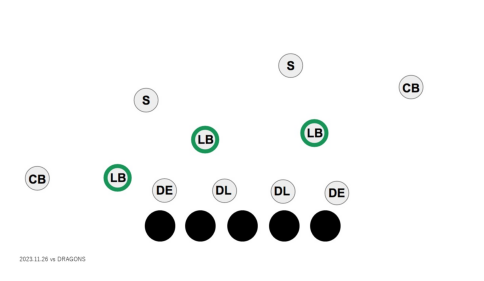

Text(value='', description='フォルダ名:', placeholder='フォルダ名を入力してください')

Best matching template: スライド32.JPG with score 197282.72860234967


<ipython-input-4-130ba14b2a39>:6: RuntimeWarning: overflow encountered in scalar subtract
  return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


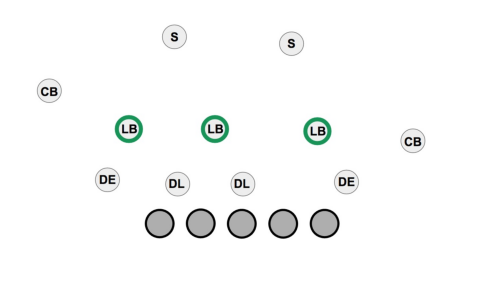

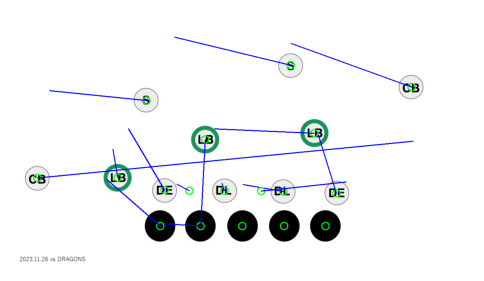

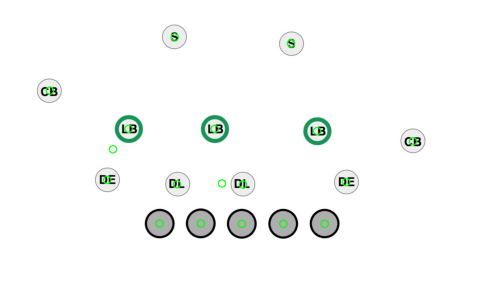

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# 入力画像の表示と手動で名前を付ける
input_image_path = "/content/drive/My Drive/path/スライド50.JPG"
input_image = cv2.imread(input_image_path)
input_circles = detect_circles(input_image)

# 入力画像を表示
def display_image(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

display_image(input_image) # 10/30(木)にこの1行を追加



# フォルダ名を入力するためのウィジェットを作成
folder_input = widgets.Text(
    value='',
    placeholder='フォルダ名を入力してください',
    description='フォルダ名:',
    disabled=False
)

# ウィジェットの処理
def on_submit(change):
    folder_name = folder_input.value
    selected_templates = [t for t in template_features if folder_name in t['folder']] #旧ver
    #selected_templates = [t for t in template_features if os.path.basename(t['folder']) == folder_name] #10/30(水)修正

    if not selected_templates:
        print("選択されたフォルダにはテンプレートがありません。")
        return

     # テンプレートの中から最も似ているものを探す 旧ver
    best_score = float('inf')
    best_template = None
    best_template_image = None

    for template in selected_templates:
        template_circles = template['circles']
        matched_circles = calculate_nearest_circles(input_circles, template_circles)
        total_score = calculate_total_score(matched_circles)

        if total_score < best_score:
            best_score = total_score
            best_template = template
            best_template_image_path = os.path.join(template['folder'], template['file_name'])
            best_template_image = cv2.imread(best_template_image_path)

    if best_template is not None:
        print(f"Best matching template: {best_template['file_name']} with score {best_score}")

        # 最も似ているテンプレート画像を表示
        display_image(best_template_image)

        # 円同士を線で結び、両画像を表示
        matched_circles = calculate_nearest_circles(input_circles, best_template['circles'])
        display_images_with_circles_and_lines(input_image, best_template_image, matched_circles)
    else:
        print("No matching template found.")

folder_input.on_submit(on_submit)

# フォルダ名入力ウィジェットを表示
display(folder_input)

